In [1]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np

from nsfdpy.grid import StaggeredGrid
from nsfdpy.field import ScalarField, VectorField
from nsfdpy.plot import StaggeredGridPlot, ScalarFieldPlot, VectorFieldPlot
from nsfdpy.config import Config
from nsfdpy.comp import CompTimeStep
from nsfdpy.ops import Curl


nsfd_config = Config("cavity.yml")

grid = StaggeredGrid(nsfd_config.geometry())
u1 = VectorField(grid, nsfd_config.initial_cond().u())
u2 = VectorField(u1)
p = ScalarField(grid, nsfd_config.initial_cond().p())
resid = []
t = [0]
u_eps = 1e-6

grid_plot = StaggeredGridPlot(grid)
s_plot = ScalarFieldPlot(grid)
vec_plot = VectorFieldPlot(grid)

comp_ts = CompTimeStep(nsfd_config.geometry(),
                   nsfd_config.boundary_cond(),
                   nsfd_config.constants(),
                   nsfd_config.solver(),
                   nsfd_config.time())

resid = 9.973062137022536e-07


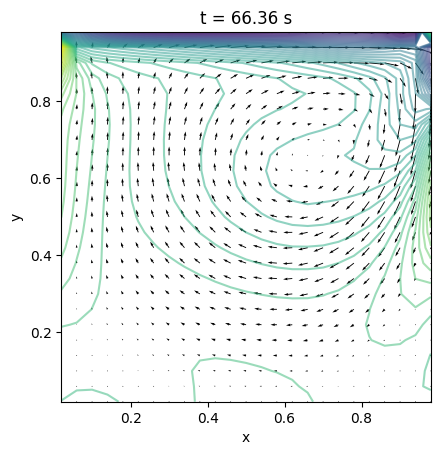

In [2]:
for n in range(10000):

    delt, (n_it, norm) = comp_ts(u2, p)

    if norm > nsfd_config.solver().eps:
        warnings.warn("Computed pressure norm is greater than eps", RuntimeWarning)

    resid.append(u2.res(u1))
    u1.copy(u2)
    t.append(t[-1] + delt)

    if resid[-1] < u_eps:
        break

print(f"resid = {resid[-1]}")

curl_u = Curl(grid, u2)
vorticity = ScalarField(grid)
for i in range(1, grid.imax + 1):
    for j in range(1, grid.jmax + 1):
        vorticity[i,j] = curl_u(i,j)

fig, ax = plt.subplots()
s_plot.contour(vorticity, ax=ax, levels=50, alpha=0.5)
vec_plot.quiver(u2, ax=ax)
ax.set_aspect("equal", "box")
ax.set_xlabel("x")
ax.set_ylabel("y")
_ = ax.set_title(f"t = {t[-1]:.2f} s")

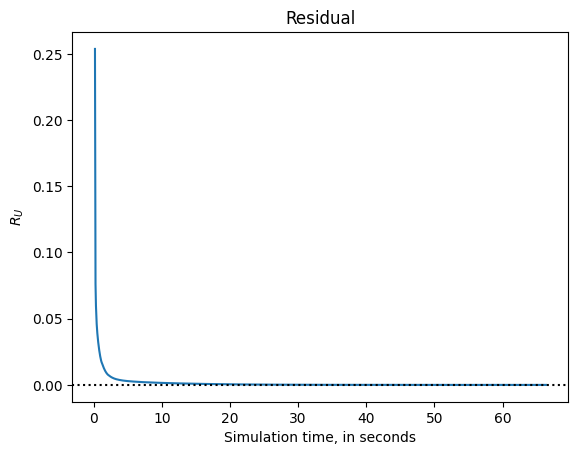

In [3]:
plt.plot(t[1:], resid)
plt.axhline(u_eps, color="k", linestyle=":")
plt.xlabel("Simulation time, in seconds")
plt.ylabel("$R_{U}$")
_ = plt.title("Residual")

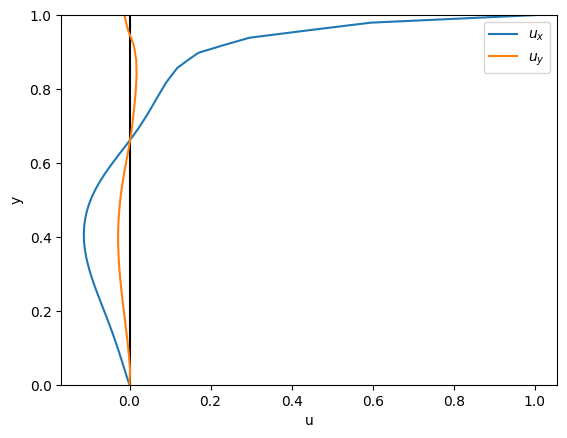

In [4]:
from nsfdpy.interp import VectorFieldInterp


u_interp = VectorFieldInterp(grid, u2)
res = []
frac = 0.665
x = frac * nsfd_config.geometry().xlength
y = np.linspace(0, nsfd_config.geometry().ylength)
for y_i in y:
    res.append(u_interp(x, y_i))

res = np.array(res)

plt.axvline(0, color="k")
plt.plot(res[:, 0], y, label="$u_x$")
plt.plot(res[:, 1], y, label="$u_y$")
plt.xlabel("u")
plt.ylabel("y")
plt.ylim(0,1)
_ = plt.legend()

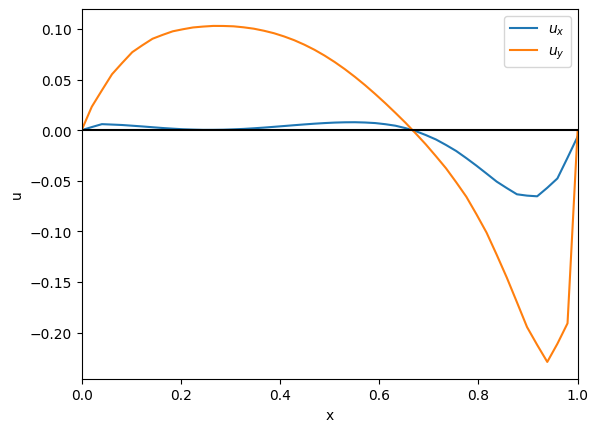

In [5]:
frac = np.interp(0, res[1:,0], y[1:])
u_interp = VectorFieldInterp(grid, u2)
res = []
x = np.linspace(0, nsfd_config.geometry().xlength)
y = frac * nsfd_config.geometry().ylength
for x_i in x:
    res.append(u_interp(x_i, y))

res = np.array(res)

plt.plot(x, res[:, 0], label="$u_x$")
plt.plot(x, res[:, 1], label="$u_y$")
plt.hlines(0, 0, 1, "k")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
_ = plt.xlim(0,1)